<a href="https://colab.research.google.com/github/MrCoeg/Skripsi/blob/main/MCP%20Best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install ipython-autotime

%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.8 MB/s eta 0:00:00
time: 296 µs (started: 2023-08-22 03:04:55 +00:00)


In [2]:
from torch.utils.data import DataLoader
from tqdm import tqdm

import torch
import cv2
import sys
import gdown

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np

sys.path.append("../")

time: 5.36 s (started: 2023-08-22 03:04:55 +00:00)


In [ ]:
file_id = "1f1YDfcYRZo2XzkJAsIg1YZHUHd0THABB"
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id={file_id}"
)
!unzip 'Dataset.zip'

file_id = "1WoGJ8Q_f2QFs5l05B1sZCFucndAPbgKc"
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id={file_id}"
)
!unzip 'Rest.zip' -d 'Dataset/rgb'

In [4]:
N_IMG_CHANNELS = 3

MODEL_IMG_SIZE = 128
RAW_IMG_SIZE = 224

DATASET_MEANS = [0.4837, 0.4650, 0.4397]
DATASET_STDS = [0.2331, 0.2338, 0.2659]

time: 697 µs (started: 2023-08-22 03:05:30 +00:00)


In [23]:

NAMES_KEYPOINTS = [
    "Wrist",
    "Thumb_CMC", "Thumb_MCP", "Thumb_DIP", "Thumb_TIP",
    "Index_MCP", "Index_PIP", "Index_DIP", "Index_TIP",
    "Middle_MCP", "Middle_PIP", "Middle_DIP", "Middle_TIP",
    "Ring_MCP", "Ring_PIP", "Ring_DIP", "Ring_TIP",
    "Pinky_MCP", "Pinky_PIP", "Pinky_DIP", "Pinky_TIP",
]

COLORMAP = {
    "tip": {"ids": [], "color": "g"},
    "dip": {"ids": [], "color": "c"},
    "pip": {"ids": [], "color": "b"},
    "mcp": {"ids": [0,1,2,3,4,5], "color": "m"},
}

# Blur Size DIP
FG = 53
FGK = 5


INDEX_KEYPOINTS = [0,1,5,9,13,17]
N_KEYPOINTS = len(INDEX_KEYPOINTS)
KEYS_KEYPOINTS = [NAMES_KEYPOINTS[i] for i in INDEX_KEYPOINTS]

time: 1.14 ms (started: 2023-08-22 03:17:53 +00:00)


In [24]:
# Model Tunning Config
train_config = {
    "data_dir": "Dataset",
    "model_neuron": 8,
    "epochs": 1000,
    "batch_size": 16,
    "batches_per_epoch": 249,
    "batches_per_epoch_val": 16,
    "learning_rate": 0.1,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

# Test Config
test_config = {
    "data_dir": "Dataset/",
    "model_neuron": 8,
    "model_path": "6 Full",
    "batch_size": 1,
    "device": torch.device("cuda"),
}

time: 834 µs (started: 2023-08-22 03:17:56 +00:00)


In [8]:
# Mengubah 3D keypoint dari Freihand Dataset menjadi 2D Keypoint
# Operasi memanfaatkan Camera Intrinsik
# Kode disediakan dari Dataset
def projectPoints(xyz, K):
    xyz = np.array(xyz)
    K = np.array(K)
    uv = np.matmul(K, xyz.T).T
    uv = uv[:, :2] / uv[:, -1:]
    return uv[INDEX_KEYPOINTS]

# Kode ini untuk mencari mean dan std dari dataset
def get_norm_params(dataloader):
    mean = 0.0
    std = 0.0
    nb_samples = 0.0

    # perulangan untuk iterate dataloader pytorch dengan return index dan batch data
    for i, sample in tqdm(enumerate(dataloader)):

        # mengambil raw image dari iterasi batch pertama
        data = sample["image_raw"]

        # berapa banyak image dalam satu batch
        batch_samples = data.size(0)

        # re-shape data menjadi [batch, channel, num_pixel]
        data = data.view(batch_samples, data.size(1), -1)

        # mendapatkan mean dan std menggunakan fungsi mean dan sum
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return {"mean": mean, "std": std}

# kode ini untuk mengubah keypoint menjadi heatmap
def vector_to_heatmaps(keypoints):
    # membuat heatmap kosong
    heatmaps = np.zeros([N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE])

    # iterate keypoint yang ada
    for k, (x, y) in enumerate(keypoints):

        # mengubah keypoint koordinate menjadi heatmap
        # kordinate x,y akan dijadikan 1 pada heatmap untuk proses blur
        x, y = int(x * MODEL_IMG_SIZE), int(y * MODEL_IMG_SIZE)
        if (0 <= x < MODEL_IMG_SIZE) and (0 <= y < MODEL_IMG_SIZE):
            heatmaps[k, int(y), int(x)] = 1

    # blur heatmap agar model menjadi robust
    heatmaps = blur_heatmaps(heatmaps)

    return heatmaps

# blur image menggunakan gaussianblur
def blur_heatmaps(heatmaps):
    heatmaps_blurred = heatmaps.copy()
    # nilai heatmap satu yang merupakan koordinat keypoint
    # dilakukan pengebluran menggunakan gaussian blur
    for k in range(len(heatmaps)):
        if heatmaps_blurred[k].max() == 1:
            heatmaps_blurred[k] = cv2.GaussianBlur(heatmaps[k], (FG, FG), FGK)
            heatmaps_blurred[k] = heatmaps_blurred[k] / heatmaps_blurred[k].max()
    return heatmaps_blurred


def CountModelParameter(model):
  parameter_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return parameter_count


# Loss function IoU

class IoULoss(nn.Module):
    def __init__(self, config):
        super(IoULoss, self).__init__()
        self.EPSILON = 1e-6
        self.max_euclidean_distance = torch.norm(
            torch.tensor([MODEL_IMG_SIZE, MODEL_IMG_SIZE]).float() -
            torch.tensor([0, 0]).float()
        )
        self.device = config["device"]



    def _op_sum(self, x):
        return x.sum(dim=-1).sum(dim=-1)

    def heatmaps_to_coordinates(self, x):
        # mendapatkan banyak image dalam batch
        batch_size = x.size(0)

        # mendapatkan nilai total dari heatmap width dan height
        sums = x.sum(dim=-1).sum(dim=-1)
        sums = sums.unsqueeze(2).unsqueeze(3)

        # normalisasi heatmap dengan membagi nilai heatmap dengan nilai total heatmap
        # sehingga hasil berada pada range 0 dan 1
        normalized = (x + self.EPSILON) / (sums+self.EPSILON)

        # mendapatkan nilai total pada normalized heatmap dari width dan height nya
        x_prob = normalized.sum(dim=2)
        y_prob = normalized.sum(dim=3)

        # membuat heatmap baru sebagai kordinat dengan size 0 hingga MODEL_IMG_SIZE - 1
        arr = torch.arange(0, MODEL_IMG_SIZE).float().unsqueeze(0).unsqueeze(1).to(self.device)
        arr = arr.expand(batch_size, N_KEYPOINTS, -1)

        # mendapatkan kordinat dengan mengkalikan normalized vector heatmap dengan heatmap kordinat baru
        # ini bertujuan untuk meningkatkan keakuratan dari keypoint output menggunakan value yang telah di normalisasi
        x = torch.sum(arr * x_prob, dim=2)
        y = torch.sum(arr * y_prob, dim=2)

        # register kordinat pada tensor
        keypoints = torch.stack([x, y], dim=-1)

        # normaliasasi kembali
        return keypoints / (MODEL_IMG_SIZE - 1)

    # Rumus untuk mendapatkan IoU
    def forward(self, y_pred, y_true):
        inter = self._op_sum(y_true * y_pred)
        union = self._op_sum((y_true ** 2) + (y_pred ** 2) - (y_true * y_pred))
        iou = (inter + self.EPSILON) / (union + self.EPSILON)
        iou = torch.mean(iou)
        return 1 - iou



# mengubah heatmap kembali menjadi kordinat
def heatmaps_to_coordinates(heatmaps):

    # mendapatkan banyak image dalam batch
    batch_size = heatmaps.shape[0]

    # mendapatkan nilai total dari heatmap width dan height
    sums = heatmaps.sum(axis=-1).sum(axis=-1)
    sums = np.expand_dims(sums, [2, 3])

    # normalisasi heatmap dengan membagi nilai heatmap dengan nilai total heatmap
    # sehingga hasil berada pada range 0 dan 1
    normalized = heatmaps / sums

    # mendapatkan nilai total pada normalized heatmap dari width dan height nya
    x_prob = normalized.sum(axis=2)
    y_prob = normalized.sum(axis=3)

    # membuat heatmap baru sebagai kordinat dengan size 0 hingga 127 -> dimensi
    arr = np.tile(np.float32(np.arange(0, MODEL_IMG_SIZE)), [batch_size, N_KEYPOINTS, 1])

    # mendapatkan kordinat dengan mengkalikan normalized vector heatmap dengan heatmap kordinat baru
    # ini bertujuan untuk meningkatkan keakuratan dari keypoint output menggunakan value yang telah di normalisasi
    x = (arr * x_prob).sum(axis=2)
    y = (arr * y_prob).sum(axis=2)

    # register kordinat pada array
    keypoints = np.stack([x, y], axis=-1)

    # normaliasasi kembali
    return keypoints / MODEL_IMG_SIZE

# Visualisasi sample data
def show_data(dataset, n_samples=4 ):
    plt.figure(figsize=[12, 4 * n_samples])
    ids = np.random.choice(dataset.__len__(), n_samples-1, replace=False)
    print(ids)

    # iterate random sample image
    for i, id_ in enumerate(ids, 1):
        sample = dataset.__getitem__(id_)

        # mendapatkan image raw
        image_raw = sample["image_raw"].numpy()
        image_raw = np.moveaxis(image_raw, 0, -1)

        #visualisasi image raw
        plt.subplot(n_samples, 4, i * 4 + 1)
        plt.imshow(image_raw)

        # mendapatkan keypoint image raw
        keypoints = sample["keypoints"].numpy()
        keypoints = keypoints * RAW_IMG_SIZE

        # visualiasai keypoint image raw menggunakan scatter dan plot
        # plot memanfaatkan colormap yang telah dibuat untuk visualisasi
        plt.scatter(keypoints[:, 0], keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                keypoints[params["ids"], 0],
                keypoints[params["ids"], 1],
                params["color"],
            )
        plt.title("Raw Image Keypoint")
        plt.axis("off")

        # mendapatkan image input
        plt.subplot(n_samples, 4, i * 4 + 2)
        image = sample["image"].numpy()
        cv2.resize(image, (RAW_IMG_SIZE,RAW_IMG_SIZE))
        image = np.moveaxis(image, 0, -1)
        plt.imshow(image)

        # mendapatkan heatmap image input
        heatmaps = sample["heatmaps"].numpy()

        # mengubah heatmap image input menjadi keypoint
        input_keypoints = heatmaps_to_coordinates(heatmaps.reshape(1, N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE))
        input_keypoints = input_keypoints[0] * MODEL_IMG_SIZE;

        # visualiasai keypoint image input menggunakan scatter dan plot
        # plot memanfaatkan colormap yang telah dibuat untuk visualisasi
        plt.scatter(input_keypoints[:, 0], input_keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                input_keypoints[params["ids"], 0],
                input_keypoints[params["ids"], 1],
                params["color"],
            )
        plt.title("Input Image")
        plt.axis("off")

        # visualisasi histogram dari image raw
        image_raw = image_raw * 255
        plt.subplot(n_samples, 4, i * 4 + 3)
        plt.hist(image_raw.ravel(),256,[0,256])
        plt.title("Raw Hist")
        plt.axis("off")

        # visualisasi histogram dari image input
        image = image * 255
        plt.subplot(n_samples, 4, i * 4 + 4)
        plt.hist(image.ravel(),256,[0,256])
        plt.title("Input Hist")
        plt.axis("off")


    plt.tight_layout()
    plt.show()


# Visualisasi prediksi model
def show_batch_predictions(batch_data, model):

    # mendapatkan image input
    inputs = batch_data["image"]
    inputs = inputs.cuda()

    # mendapatkan actual heatmap
    true_keypoints = batch_data["heatmaps"].numpy()
    batch_size = true_keypoints.shape[0]

    # mendapatkan actual keypoint
    true_keypoints = heatmaps_to_coordinates(true_keypoints.reshape(batch_size, N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE))

    # melakukan prediksi
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()

    # mendapatkan prediksi heatmap
    pred_heatmaps = pred_heatmaps.detach().numpy()

    # mendapatkan prediksi keypoint
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    # mendapatkan setiap input image
    inputs = inputs.cpu()
    images = inputs.numpy()
    images = np.moveaxis(images, 1, -1)

    plt.figure(figsize=[12, 4 * batch_size])

    # iterate setiap input image
    for i in range(batch_size):

        # mendapatkan image pada setiap iterasi
        image = images[i]

        # resize image menjadi 224 * 224
        image = cv2.resize(image, (RAW_IMG_SIZE, RAW_IMG_SIZE))

        # resize keypoint mengikuti ukuran image
        true_keypoints_img = true_keypoints[i] * RAW_IMG_SIZE
        pred_keypoints_img = pred_keypoints[i] * RAW_IMG_SIZE

        # visualisasi image input
        plt.subplot(batch_size, 3, i * 3 + 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        # visualisasi image input untuk actual keypoint
        plt.subplot(batch_size, 3, i * 3 + 2)
        plt.imshow(image)
        plt.scatter(true_keypoints_img[:, 0], true_keypoints_img[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                true_keypoints_img[params["ids"], 0],
                true_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("True Keypoints")
        plt.axis("off")

        # visualisasi image input untuk prediksi keypoint
        plt.subplot(batch_size, 3, i * 3 + 3)
        plt.imshow(image)
        plt.scatter(pred_keypoints_img[:, 0], pred_keypoints_img[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                pred_keypoints_img[params["ids"], 0],
                pred_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("Pred Keypoints")
        plt.axis("off")
    plt.tight_layout()
    plt.tight_layout()
    plt.show()

time: 4.08 ms (started: 2023-08-22 03:05:52 +00:00)


In [31]:
import numpy as np
import os
from PIL import Image
import json
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import random

class FreiHAND(Dataset):

    def __init__(self, config, set_type="train"):

        # mendapatkan image path
        self.set_type = set_type
        self.device = config["device"]
        self.image_dir = os.path.join(config["data_dir"], "rgb")
        self.image_names = np.sort(os.listdir(self.image_dir))

        # filtering image
        self.image_names = [img for img in self.image_names if not img.endswith(('.ipynb_checkpoint', '.zip'))]

        # mendapatkan intrinsik kamera
        fn_K_matrix = os.path.join(config["data_dir"], "training_K.json")
        with open(fn_K_matrix, "r") as f:
            self.K_matrix = np.array(json.load(f))

        # mendapatkan 3d keypoint
        fn_anno = os.path.join(config["data_dir"], "training_xyz.json")
        with open(fn_anno, "r") as f:
            self.anno = np.array(json.load(f))

        # fn_tunning_anno = "keypoint_tuning_xyz.json"
        # with open(fn_tunning_anno, "r") as f:
        #     self.tunning_anno = np.array(json.load(f))

        # split dataset menjadi train, val dan test
        if set_type == "train":
            n_start = 0
            n_end = 12000
        elif set_type == "val":
            n_start = 12000
            n_end = 14000
        else:
            n_start = 14000
            n_end = 15000

        self.image_names = self.image_names[n_start:n_end]
        # self.K_matrix = self.K_matrix[n_start:n_end]
        # self.anno = self.anno[n_start:n_end]

        # Image preprocesing dan augmentation

        # raw image preprocesing
        self.image_raw_transform = transforms.ToTensor()

        # input image preprocesing
        self.image_transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),

            ]
        )

        # input image preprocesing dengan flip horizontal
        self.image_transform_flipped_horizontal = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
            ]
        )

        # input image preprocesing dengan flip vertical
        self.image_transform_flipped_vertical = transforms.Compose(
            [
                transforms.RandomVerticalFlip(1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
            ]
        )

        # input image preprocesing dengan flip horizontal dan flip vertical
        self.image_transform_flipped_both = transforms.Compose(
            [

                transforms.RandomHorizontalFlip(1),
                transforms.RandomVerticalFlip(1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
            ]
        )

        self.image_transform_resize = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
            ]
        )

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):

        # mendapatkan image sesuai index pemanggil
        image_name = self.image_names[idx]
        anno_idx = int(image_name[2:8]) % 32560
        # instance image menggunakan PIL
        image_raw = Image.open(os.path.join(self.image_dir, image_name))

        image = self.image_transform_resize(image_raw)

        # mengubah 3D keypoint menjadi 2D Keypoint menggunakan Intrinsik kamera
        keypoints = projectPoints(self.anno[anno_idx], self.K_matrix[anno_idx])

        # Normalisasi keypoint
        keypoints = keypoints / RAW_IMG_SIZE

        # mengubah keypoint menjadi heatmaps
        heatmaps = vector_to_heatmaps(keypoints)

        # mengubah heatmap jadi tensor
        heatmaps = torch.from_numpy(np.float32(heatmaps))

        # melakukan image preprocesing dan augmentation terhadapa input image dan heatmapnya
        flip_probability = random.random()

        # if  self.set_type == "test":
        flip_probability = 0.1

        if 0 < flip_probability < 0.25:
          image = self.image_transform(image)
        elif 0.25 < flip_probability < 0.5:
          image = self.image_transform_flipped_horizontal(image)
          heatmaps = transforms.functional.hflip(heatmaps)
        elif 0.5 < flip_probability < 0.75:
          image = self.image_transform_flipped_vertical(image)
          heatmaps = transforms.functional.vflip(heatmaps)
        else:
          image = self.image_transform_flipped_both(image)
          heatmaps = transforms.functional.hflip(heatmaps)
          heatmaps = transforms.functional.vflip(heatmaps)

        # mengubah image_raw dan keypoint jadi tensor
        image_raw = self.image_raw_transform(image_raw)
        keypoints = torch.from_numpy(keypoints)

        return {
            "image": image,
            "keypoints": keypoints,
            "heatmaps": heatmaps,
            "image_name": image_name,
            "image_raw": image_raw,
        }


time: 3.4 ms (started: 2023-08-22 04:04:38 +00:00)


[11621  3814  3128]


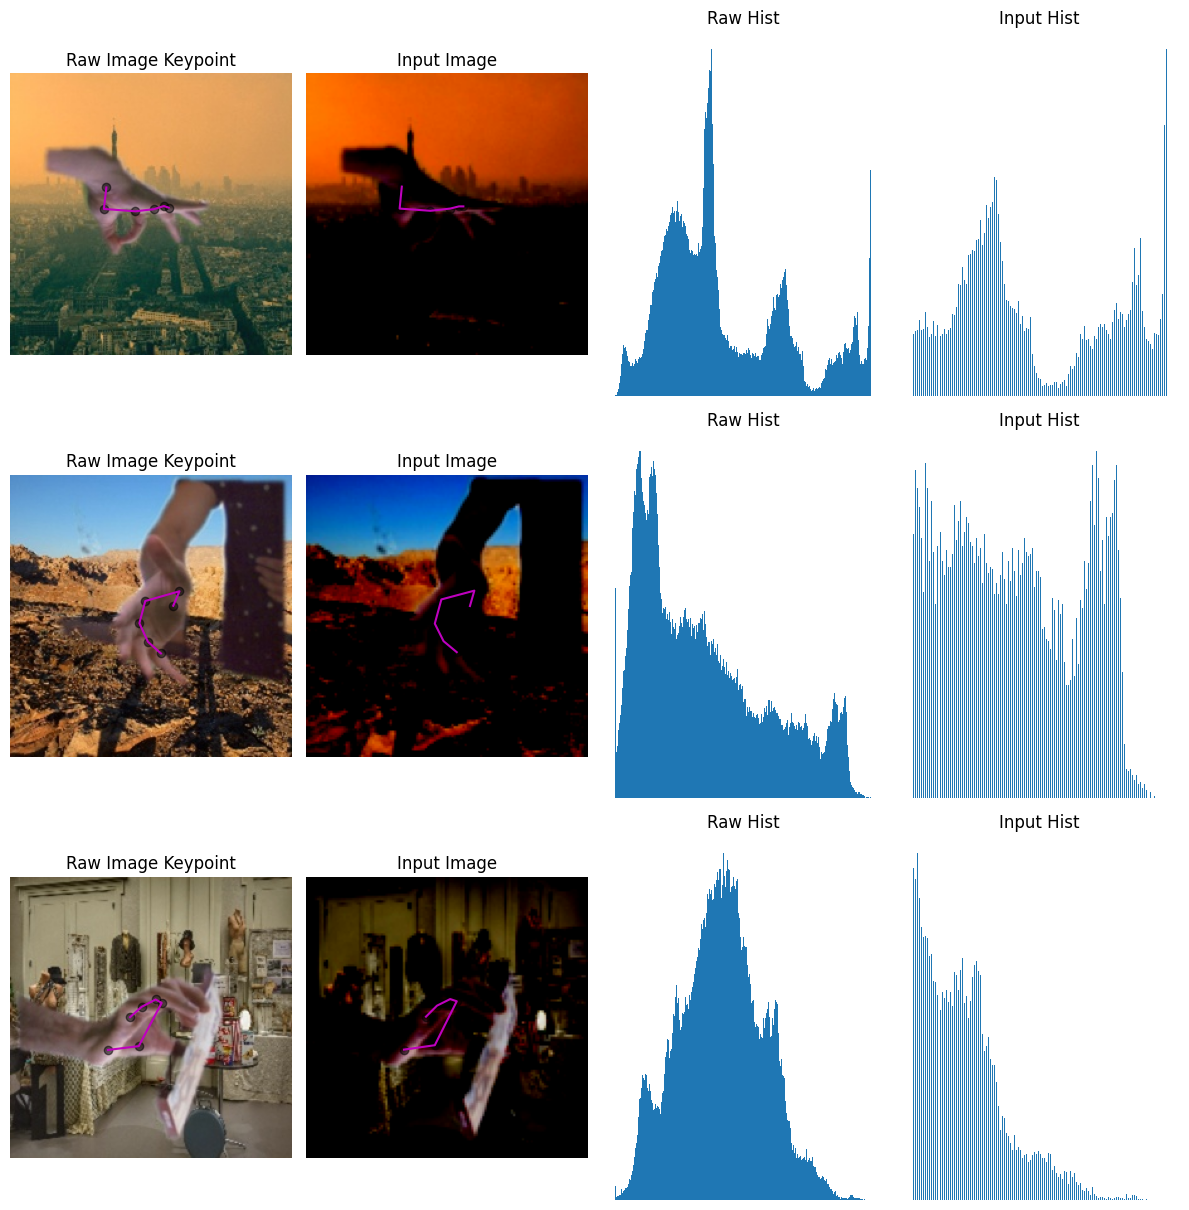

In [10]:
# membuat training dataset
train_dataset = FreiHAND(config=train_config, set_type="train")
train_dataloader = DataLoader(
    train_dataset, train_config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)
show_data(train_dataset, n_samples=4)


time: 5.26 s (started: 2023-08-22 03:06:03 +00:00)


[2121  116  469]


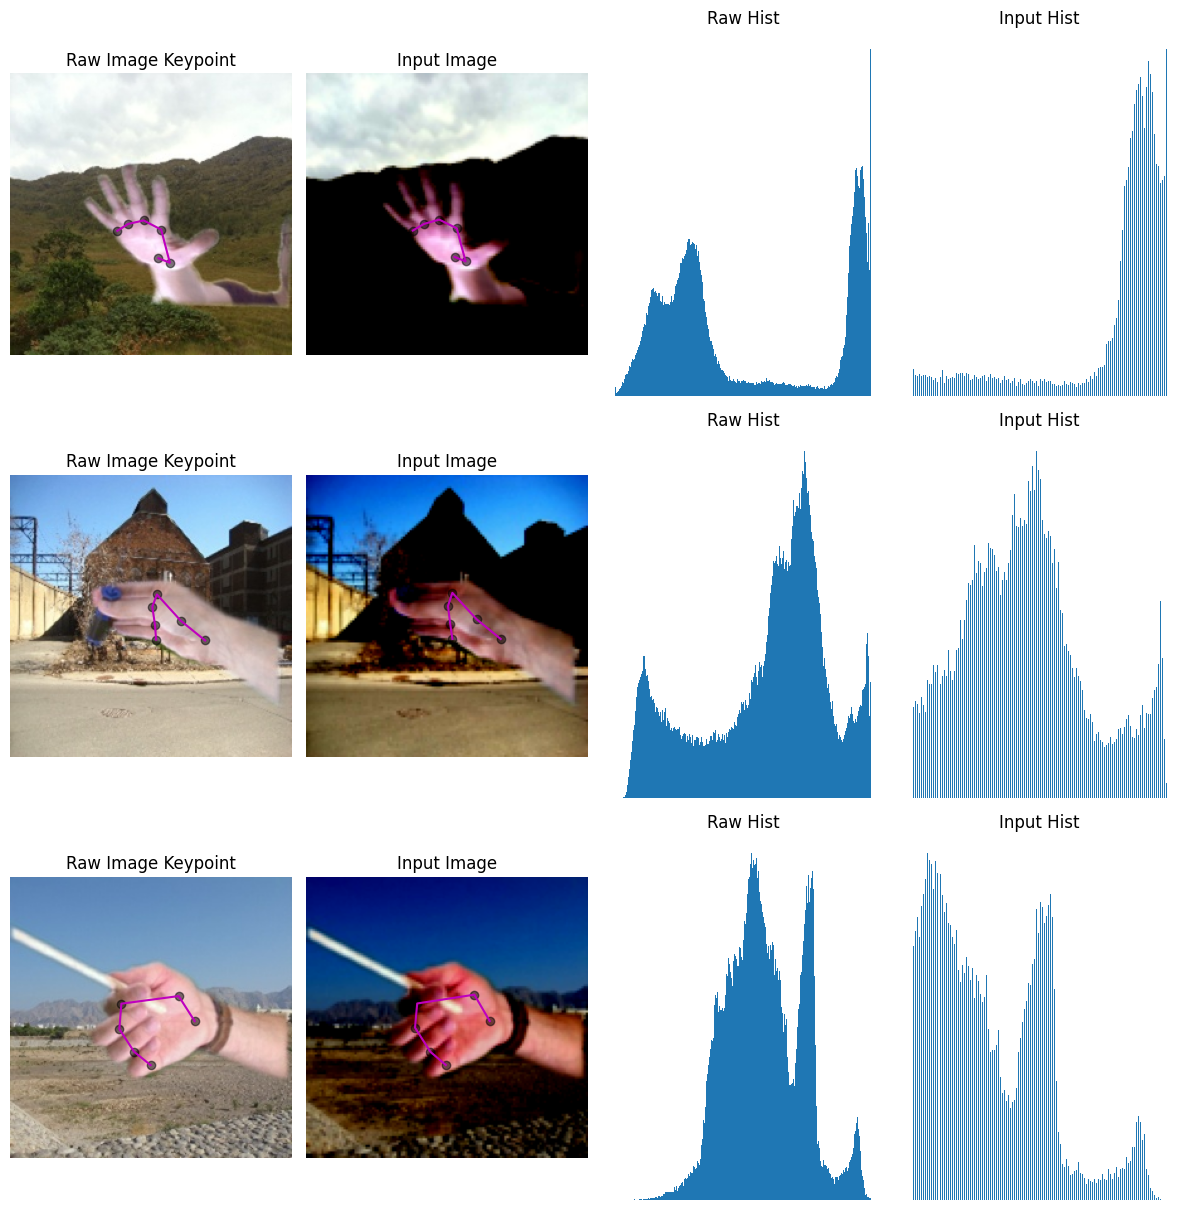

time: 5.97 s (started: 2023-08-22 03:06:08 +00:00)


In [11]:
# membuat eval dataset
val_dataset = FreiHAND(config=train_config, set_type="val")
val_dataloader = DataLoader(
    val_dataset, train_config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

# visualisasi eval
show_data(val_dataset, n_samples=4)

[691   0  23]


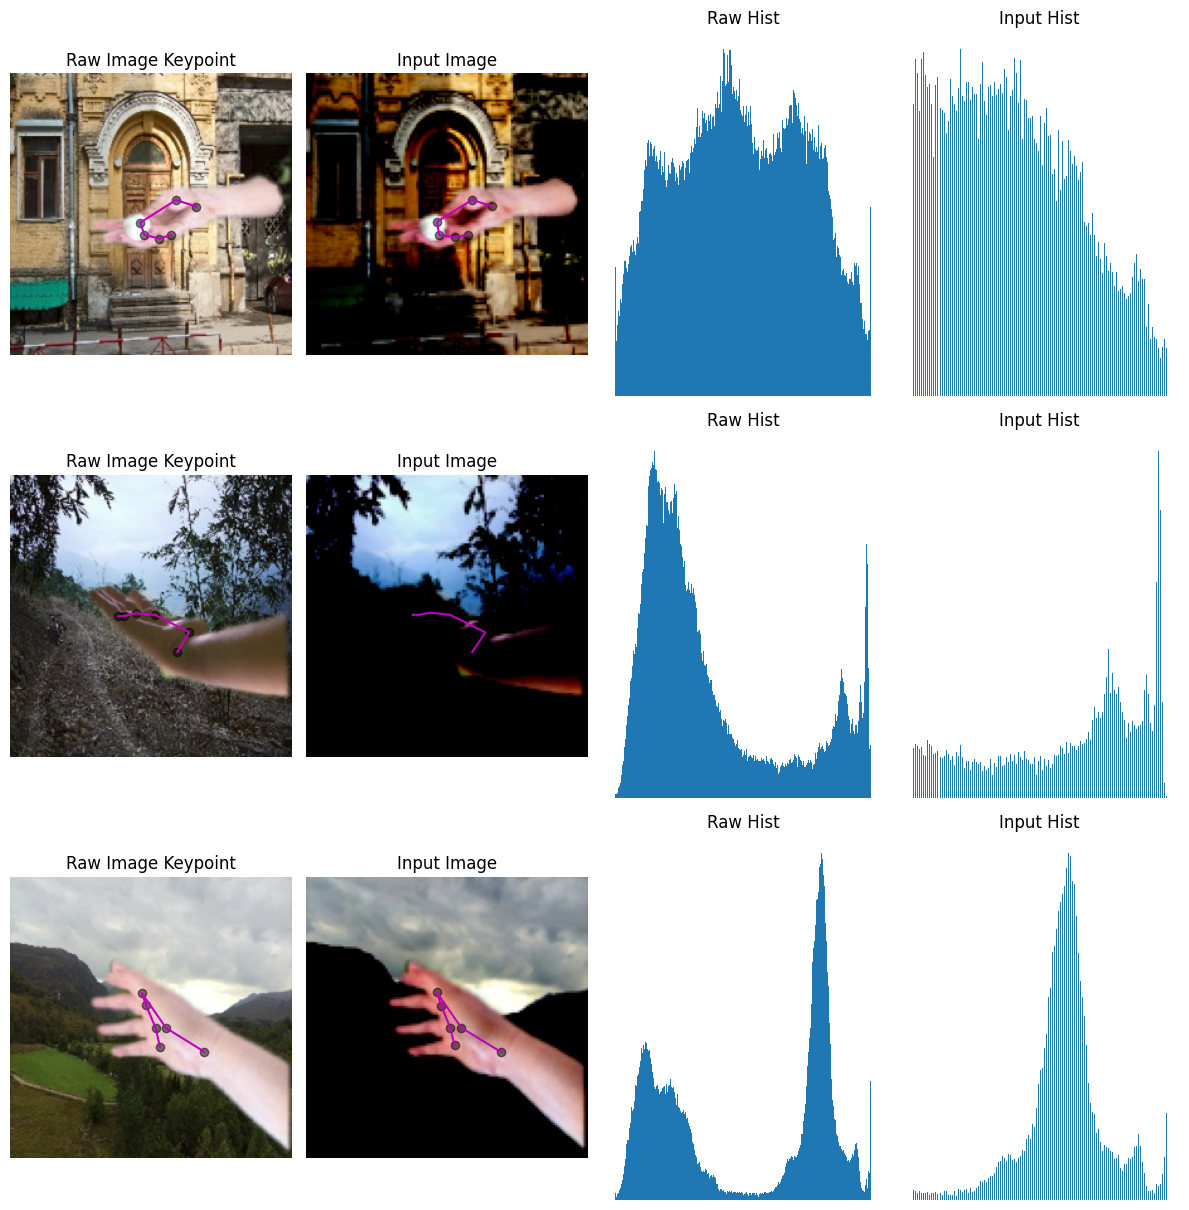

time: 6.23 s (started: 2023-08-22 04:04:49 +00:00)


In [32]:


# membuat dataset testing
test_dataset = FreiHAND(config=test_config, set_type="test")
test_dataloader = DataLoader(
    test_dataset, test_config["batch_size"], shuffle=True, drop_last=False, num_workers=2,
)
show_data(test_dataset, n_samples=4)


In [13]:
import torch
import torch.nn as nn

# Depthwise Separable Convolution Block
class DepthwiseSeparableConvBlock(nn.Module):
  def __init__(self, in_depth, out_depth):
      super().__init__()
      self.double_conv = nn.Sequential(

          nn.BatchNorm2d(in_depth),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=True),
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=1,stride=1,padding=0,bias=True),

          nn.BatchNorm2d(in_depth),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=True),
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=1,stride=1,padding=0,bias=True),

          nn.BatchNorm2d(in_depth),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=True),
          nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=True),
      )

      self.skip = nn.Sequential(
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=True),
          nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=True),
      )



  def forward(self, x):
      double_conv = self.double_conv(x)
      skip = self.skip(x)
      return double_conv + skip


class DepthwiseUNet(nn.Module):
  def __init__(self, in_channel, out_channel, model_neurons):
      super().__init__()
      self.quant = torch.ao.quantization.QuantStub()
      self.dequant = torch.ao.quantization.DeQuantStub()
      # self.post_processing = PostProcessOutput(out_channel, 128)

      self.maxpool = nn.MaxPool2d(2)
      self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

      self.conv_in = nn.Sequential(
          nn.Conv2d(in_channel, model_neurons, kernel_size=3, padding=1, bias=False),
          nn.BatchNorm2d(model_neurons),
          nn.ReLU(inplace=True),
      )

      # ConvBlock Encoder
      self.conv_down1 = DepthwiseSeparableConvBlock(model_neurons, model_neurons * 2)
      self.conv_down2 = DepthwiseSeparableConvBlock(model_neurons * 2, model_neurons * 4)
      self.conv_down3 = DepthwiseSeparableConvBlock(model_neurons * 4, model_neurons * 8)

      # # Middle
      # self.conv_middle1 = DepthwiseSeparableConvBlock(model_neurons, model_neurons*2)
      # self.conv_middle2 = DepthwiseSeparableConvBlock(model_neurons*2, model_neurons*4)
      # self.conv_middle3 = DepthwiseSeparableConvBlock(model_neurons*4, model_neurons*8)


      # ConvBlock Bottleneck
      self.conv_bottleneck = DepthwiseSeparableConvBlock(model_neurons * 8, model_neurons * 8)


      # ConvBlock Decoder
      self.conv_up1 = DepthwiseSeparableConvBlock(
          model_neurons * 8, model_neurons * 4
      )
      self.conv_up2 = DepthwiseSeparableConvBlock(
          model_neurons * 4, model_neurons * 2
      )
      self.conv_up3 = DepthwiseSeparableConvBlock(
          model_neurons * 2 , model_neurons
      )
      # self.conv_up4 = DepthwiseSeparableConvBlock(
      #     MODEL_NEURONS * 2 + MODEL_NEURONS, MODEL_NEURONS
      # )


      # Output layer
      self.conv_out = nn.Sequential(
          nn.Conv2d(model_neurons, out_channel, kernel_size=3, padding=1, bias=False),
          nn.Sigmoid(),
      )



  def forward(self, x):
      # quant = self.quant(x)
      conv_re = self.conv_in(x)
      conv_d1 = self.conv_down1(conv_re)
      conv_d2 = self.conv_down2(self.maxpool(conv_d1))
      conv_d3 = self.conv_down3(self.maxpool(conv_d2))

      conv_b = self.conv_bottleneck(self.maxpool(conv_d3))

      conv_u1 = self.conv_up1(self.upsample(conv_b) + conv_d3)
      conv_u2 = self.conv_up2(self.upsample(conv_u1) + conv_d2)
      conv_u3 = self.conv_up3(self.upsample(conv_u2) + conv_d1)
      out = self.conv_out(conv_u3)
      # dequant = self.dequant(out)
      # post_processed = self.post_processing(dequant)
      return out


time: 2.48 ms (started: 2023-08-22 03:06:19 +00:00)


In [20]:
import numpy as np
import torch

# membuat class custom untuk training
class Trainer:
    def __init__(self, model, criterion, optimizer, config, scheduler=None):
        self.best_model = model.state_dict()
        self.current_best_lost = 1
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.loss = {"train": [], "val": []}
        self.epochs = config["epochs"]
        self.batches_per_epoch = config["batches_per_epoch"]
        self.batches_per_epoch_val = config["batches_per_epoch_val"]
        self.device = config["device"]
        self.scheduler = scheduler
        self.checkpoint_frequency = 20
        self.early_stopping_epochs = 10
        self.early_stopping_avg = 10
        self.early_stopping_precision = 5

    def train(self, train_dataloader, val_dataloader, test_dataloader):
        for epoch in range(self.epochs):
            self._epoch_train(train_dataloader)
            self._epoch_eval(val_dataloader)
            print(
                "Epoch: {}/{}, Train Loss={}, Val Loss={}".format(
                    epoch + 1,
                    self.epochs,
                    np.round(self.loss["train"][-1], 10),
                    np.round(self.loss["val"][-1], 10),
                )
            )
            # visualisasi testing
            for data in test_dataloader:
                show_batch_predictions(data, model)
                break

            # menurukan learning rate jika tidak ada perkembangan
            if self.scheduler is not None:
                # self.scheduler.step(self.loss["train"][-1])
                self.scheduler.step()

            if (self.loss["val"][-1] < self.current_best_lost):
              self.best_model = model.state_dict()
              self.current_best_lost = self.loss["val"][-1]


            # saving model setiap 20 epoch
            if (epoch + 1) % self.checkpoint_frequency == 0:
                torch.save(
                    self.model.state_dict(), "model_{}".format(str(epoch + 1).zfill(3))
                )

            # early stopping untuk menghindari overfitting
            if epoch < self.early_stopping_avg:
                min_val_loss = np.round(np.mean(self.loss["val"]), self.early_stopping_precision)
                no_decrease_epochs = 0

            # early stop akan terjadi jika nilai rata - rata dari 10 loss val terakhir tidak kunjung menurun selama
            # early_stopping_epochs berturut turut
            else:
                val_loss = np.round(
                    np.mean(self.loss["val"][-self.early_stopping_avg:]),
                                    self.early_stopping_precision
                )
                if val_loss >= min_val_loss:
                    no_decrease_epochs += 1
                else:
                    min_val_loss = val_loss
                    no_decrease_epochs = 0

            if no_decrease_epochs > self.early_stopping_epochs:
                print("Early Stopping")
                break

        torch.save(self.model.state_dict(), "model_final")
        return self.model

    def _epoch_train(self, dataloader):

        # mengubah mode model menjadi mode training
        self.model.train()
        running_loss = []
        # iterate data training
        for i, data in enumerate(dataloader, 0):
            # mendapatkan input image batch
            inputs = data["image"].to(self.device)
            # mendapatkan input heatmap image batch
            labels = data["heatmaps"].to(self.device)

            # memngubah gradient menjadi zero untuk mencegah terjadinya kesalahan update parameter model
            self.optimizer.zero_grad()

            # melakukan prediksi training
            outputs = self.model(inputs)

            # menghitung loss
            loss = self.criterion(outputs, labels)

            # menghitung gradient untuk update parameter
            loss.backward()

            # update parameter model
            self.optimizer.step()

            # append loss batch ini
            running_loss.append(loss.item())


        # final loss untuk epoch training ini
        epoch_loss = np.mean(running_loss)
        self.loss["train"].append(epoch_loss)

    def _epoch_eval(self, dataloader):

        # mengubah mode model menjadi mode eval
        self.model.eval()
        running_loss = []

        # nonaktifkan gradient komputasi
        with torch.no_grad():

            # iterate data training eval
            for i, data in enumerate(dataloader, 0):
                # mendapatkan input image batch
                inputs = data["image"].to(self.device)
                # mendapatkan input heatmap image batch
                labels = data["heatmaps"].to(self.device)

                # melakukan prediksi eval
                outputs = self.model(inputs)

                # menghitung loss
                loss = self.criterion(outputs, labels)

                overall_loss = loss

                # append loss batch ini
                running_loss.append(loss.item())

                # final loss untuk epoch eval ini
            epoch_loss = np.mean(running_loss)
            self.loss["val"].append(epoch_loss)



time: 3.47 ms (started: 2023-08-22 03:13:05 +00:00)


In [28]:
# membuat model U-Net
model = DepthwiseUNet(N_IMG_CHANNELS, N_KEYPOINTS, train_config["model_neuron"])
model = model.to(train_config["device"])

# membuat loss function
criterion = IoULoss(train_config)

# membuat optimizer
optimizer = optim.SGD(model.parameters(), lr=train_config["learning_rate"], momentum=0.8)

# membuat scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.25)

model.eval()

DepthwiseUNet(
  (quant): QuantStub()
  (dequant): DeQuantStub()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (conv_in): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_down1): DepthwiseSeparableConvBlock(
    (double_conv): Sequential(
      (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
      (3): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
      (7): Con

time: 26.1 ms (started: 2023-08-22 03:20:06 +00:00)


Epoch: 1/1000, Train Loss=0.6657526954, Val Loss=0.5675728439


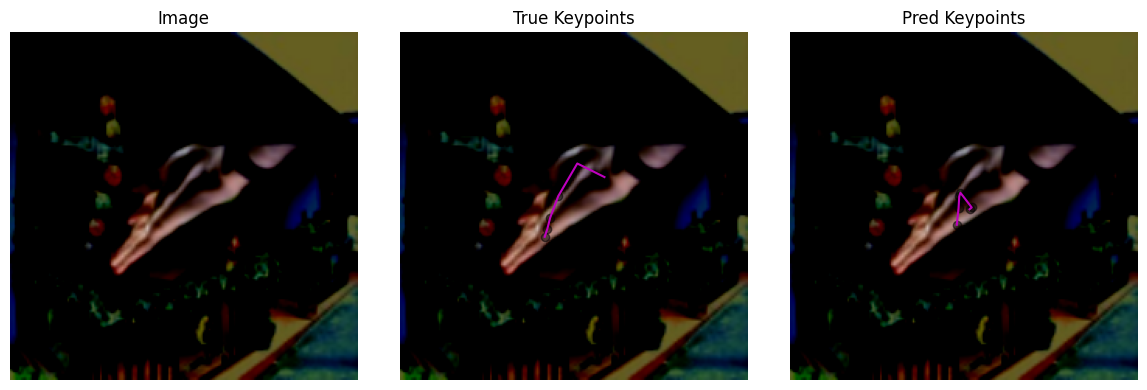

Epoch: 2/1000, Train Loss=0.5052311898, Val Loss=0.5138484871


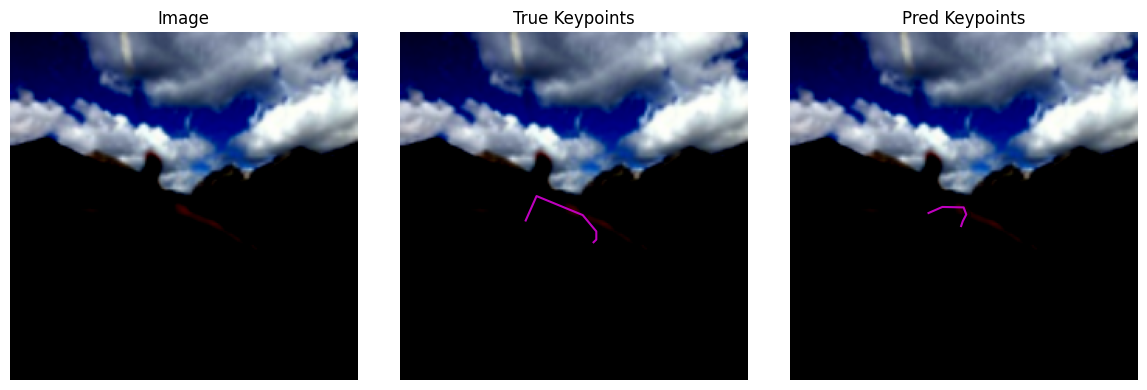

Epoch: 3/1000, Train Loss=0.4635914466, Val Loss=0.4456184318


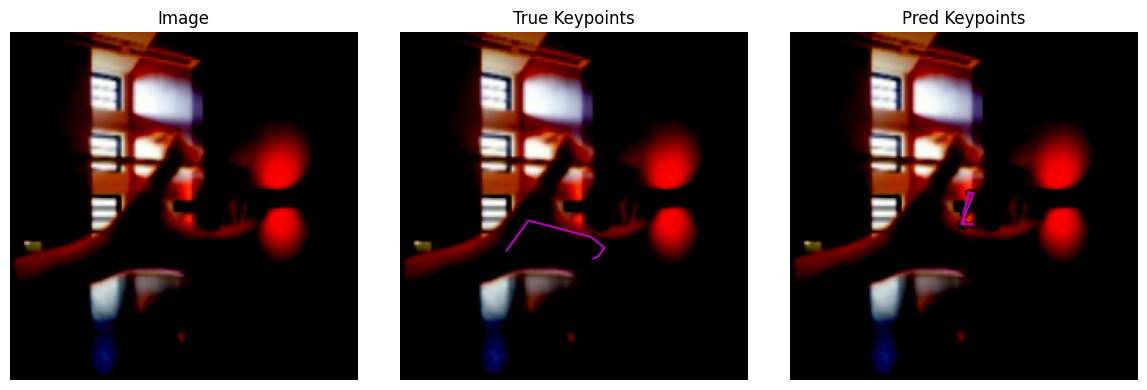

Epoch: 4/1000, Train Loss=0.4342799215, Val Loss=0.4265430892


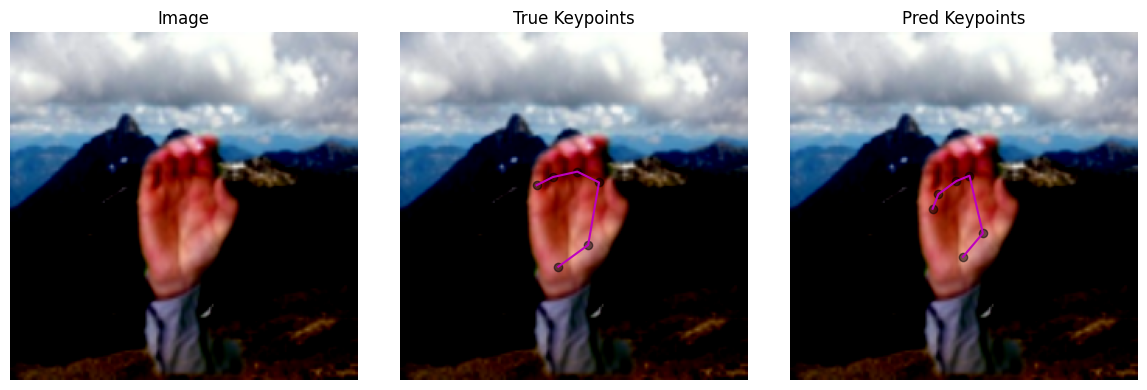

Epoch: 5/1000, Train Loss=0.4110367923, Val Loss=0.4194596617


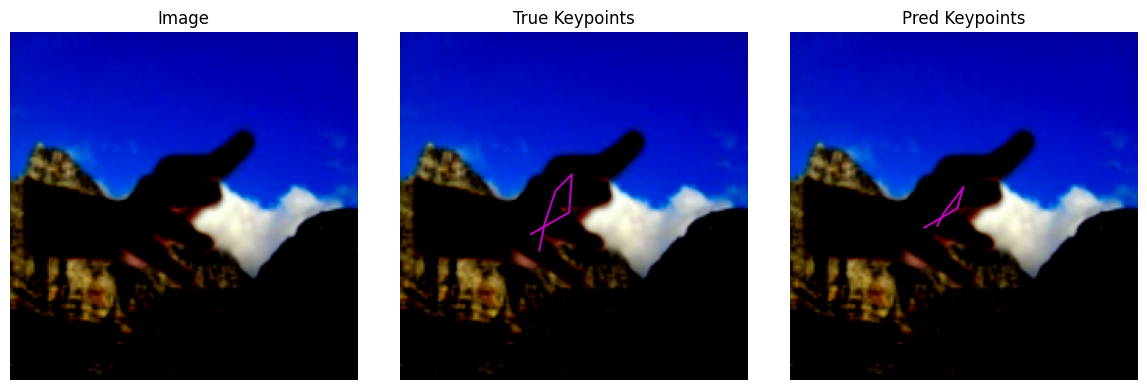

Epoch: 6/1000, Train Loss=0.3922290436, Val Loss=0.3896603948


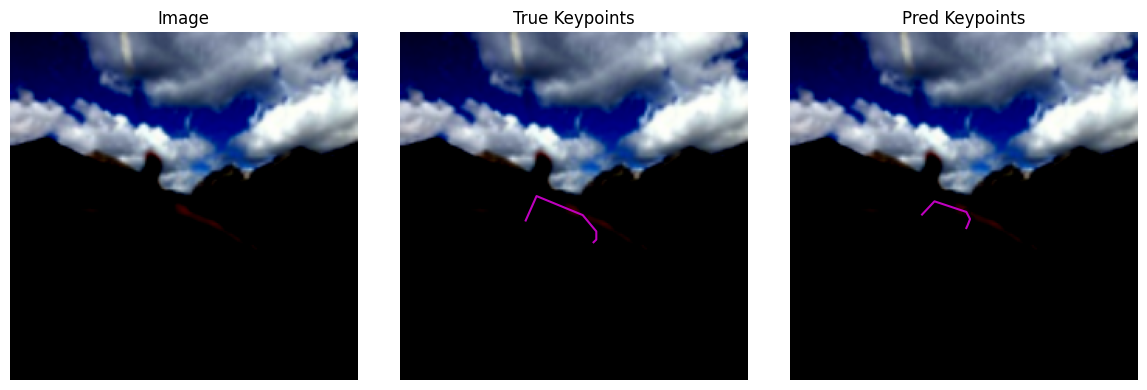

Epoch: 7/1000, Train Loss=0.3770349798, Val Loss=0.3811211162


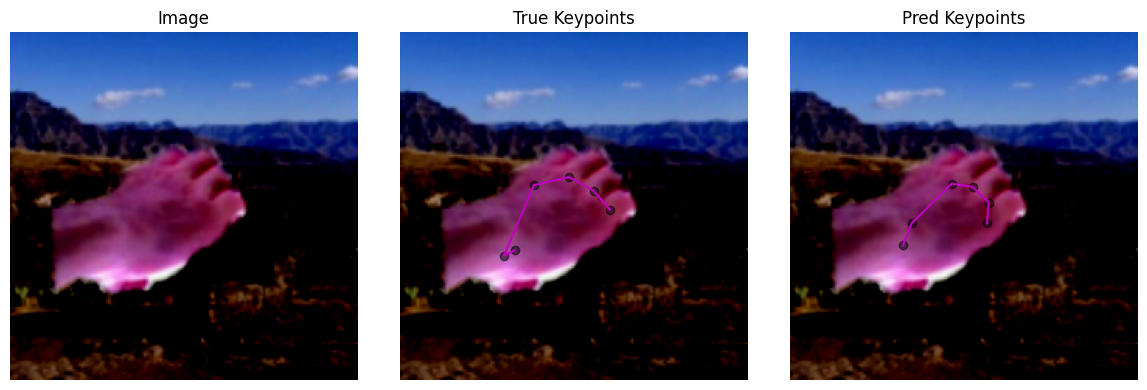

Epoch: 8/1000, Train Loss=0.3322508412, Val Loss=0.3390177622


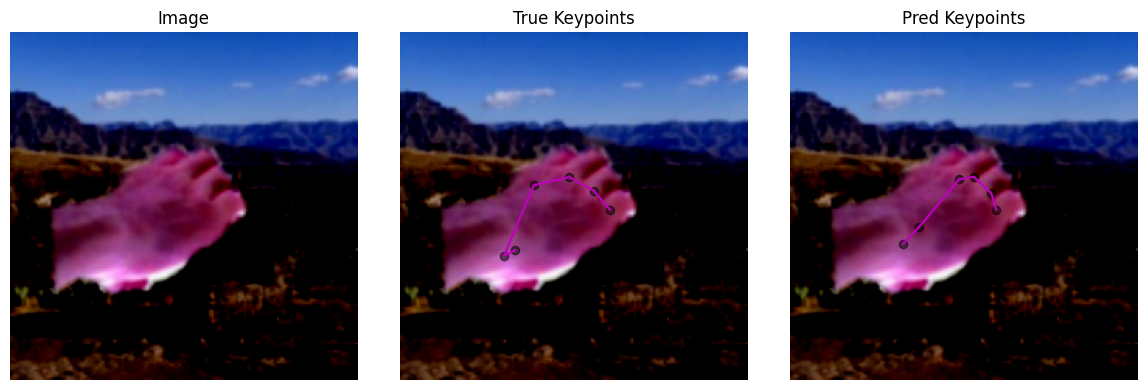

Epoch: 9/1000, Train Loss=0.3224139773, Val Loss=0.3335749077


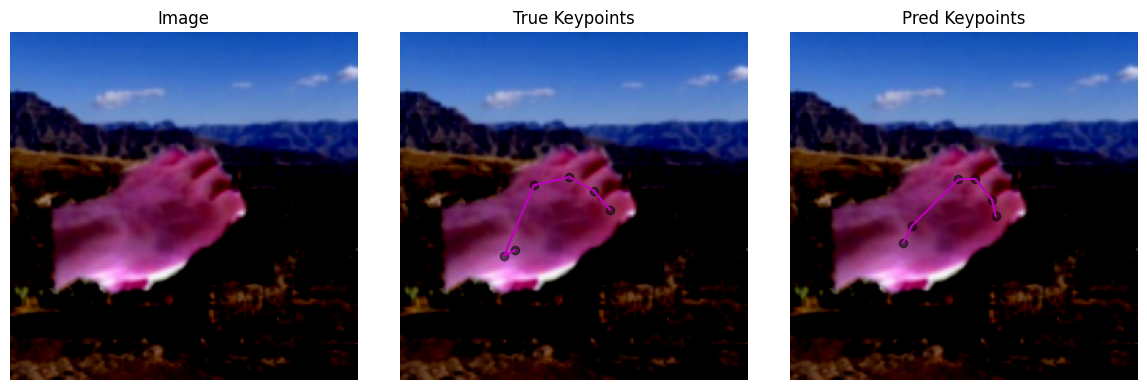

Epoch: 10/1000, Train Loss=0.3170936232, Val Loss=0.330713719


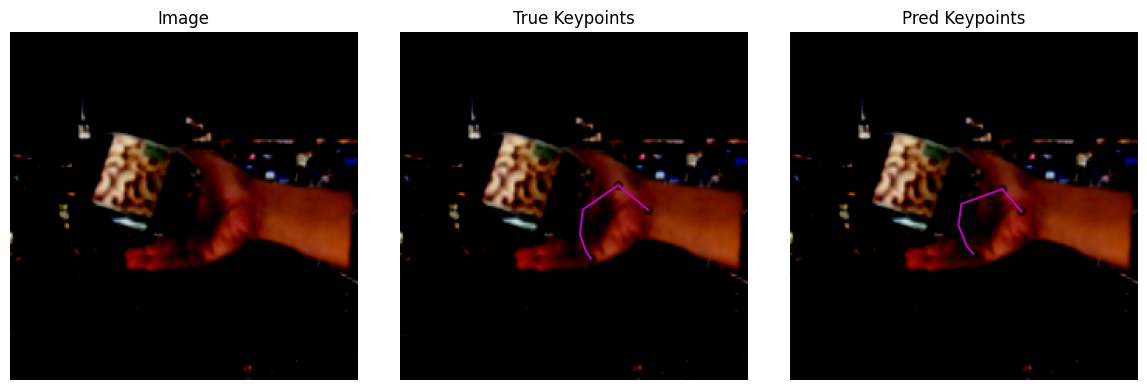

Epoch: 11/1000, Train Loss=0.3120268676, Val Loss=0.3282726856


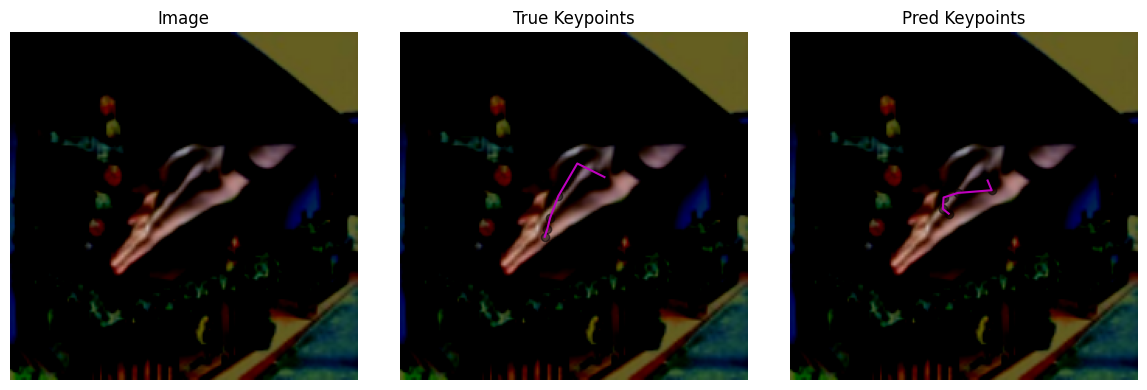

Epoch: 12/1000, Train Loss=0.3070353301, Val Loss=0.3224173631


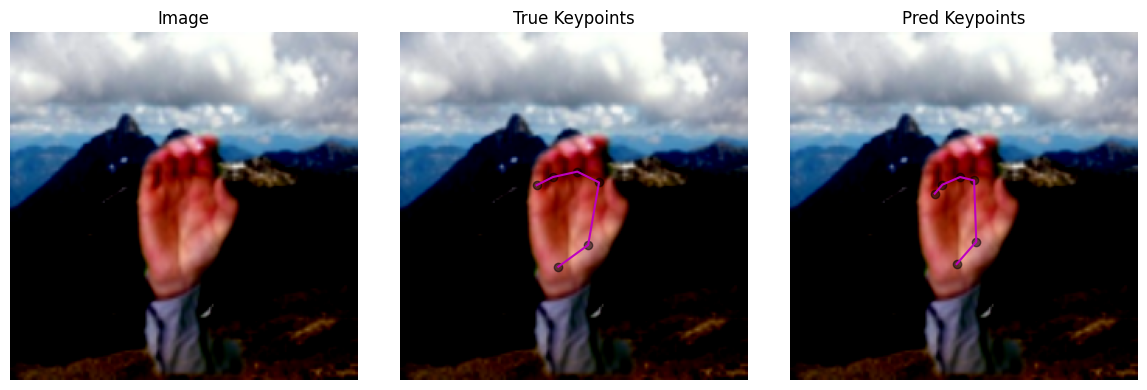

Epoch: 13/1000, Train Loss=0.3023877412, Val Loss=0.3226903298


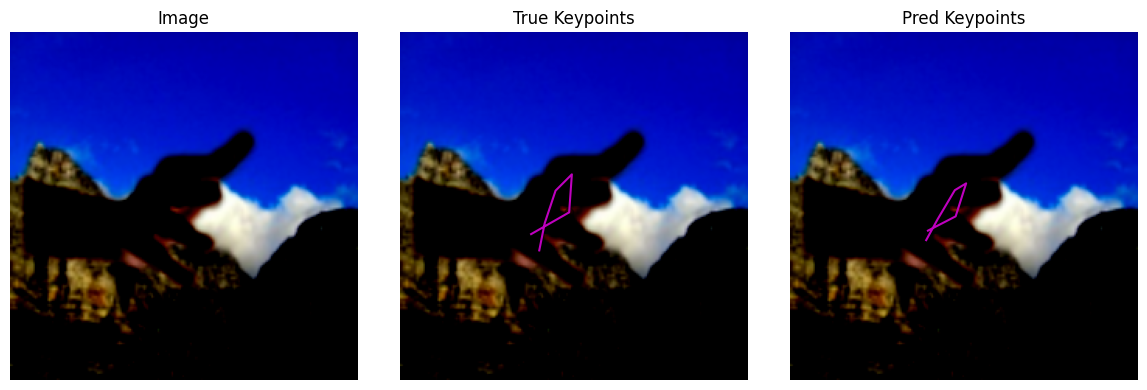

Epoch: 14/1000, Train Loss=0.2979410363, Val Loss=0.3186927763


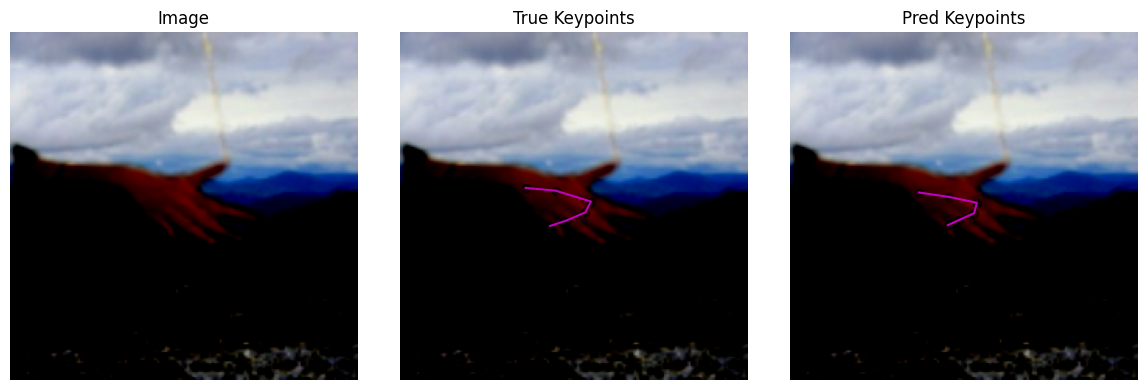

Epoch: 15/1000, Train Loss=0.2806561299, Val Loss=0.3082154855


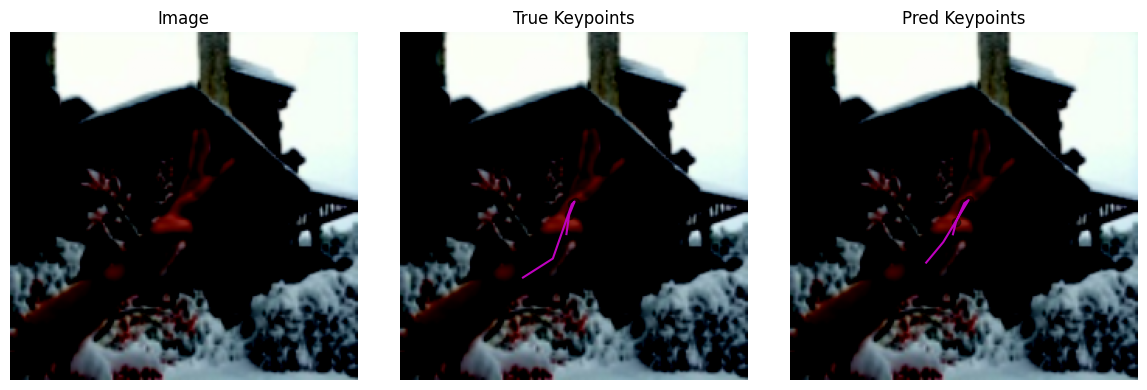

Epoch: 16/1000, Train Loss=0.277670122, Val Loss=0.3079794888


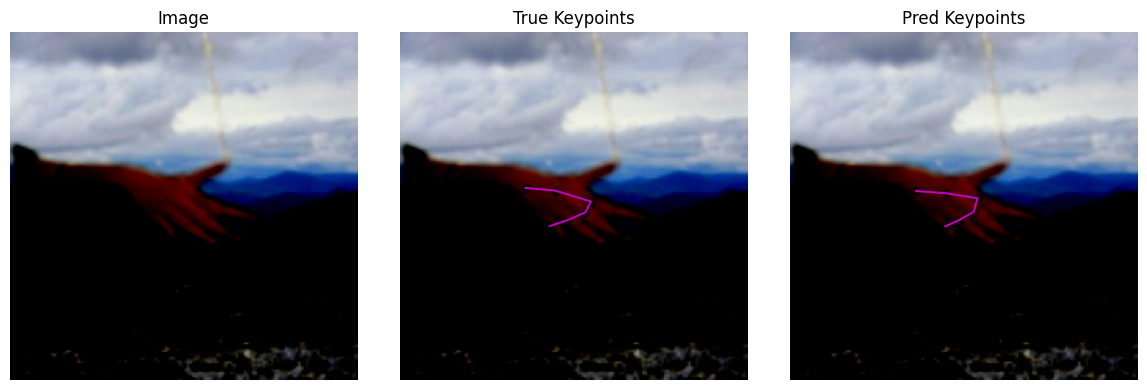

Epoch: 17/1000, Train Loss=0.276185329, Val Loss=0.3051847752


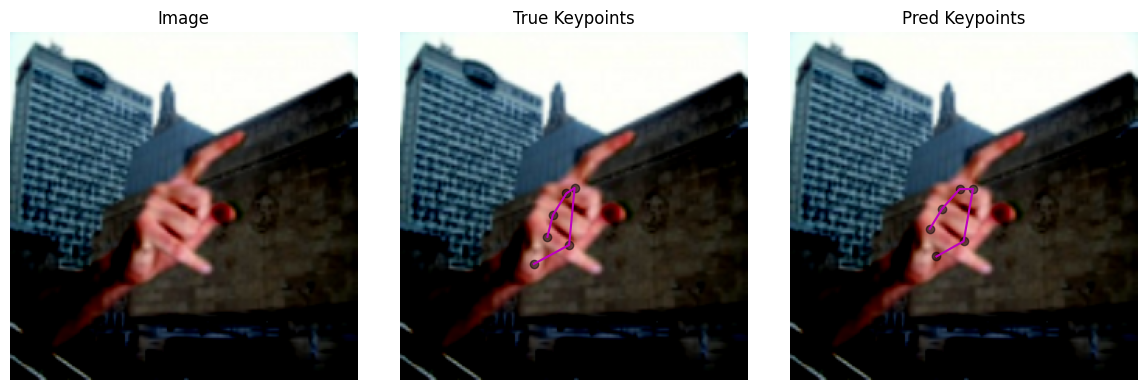

Epoch: 18/1000, Train Loss=0.2738359477, Val Loss=0.3058953387


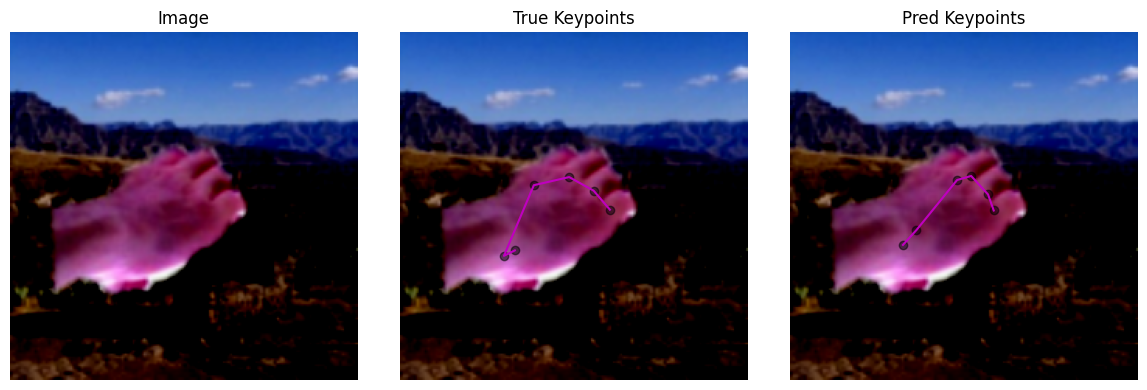

Epoch: 19/1000, Train Loss=0.2728471703, Val Loss=0.3044589446


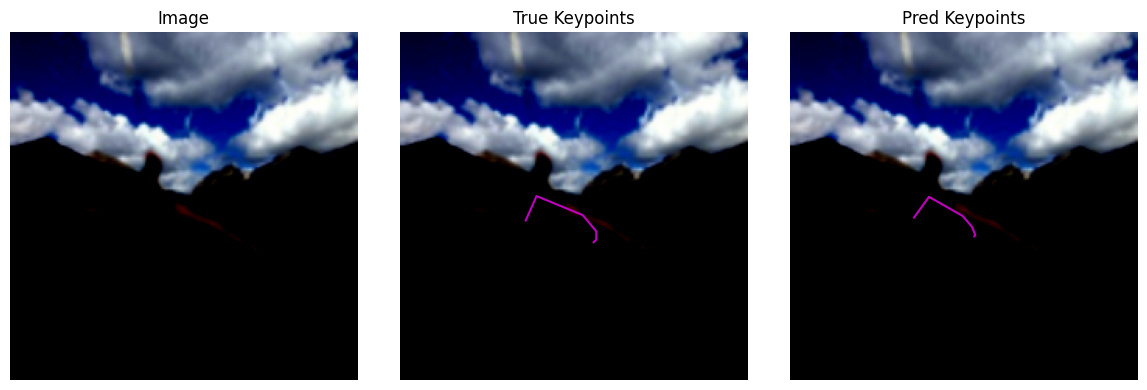

Epoch: 20/1000, Train Loss=0.2713607186, Val Loss=0.3036782152


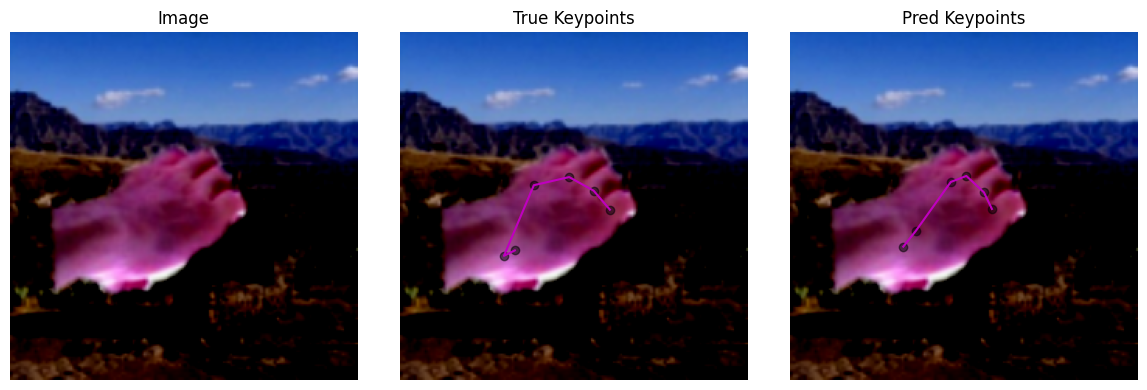

Epoch: 21/1000, Train Loss=0.2702928034, Val Loss=0.3027666641


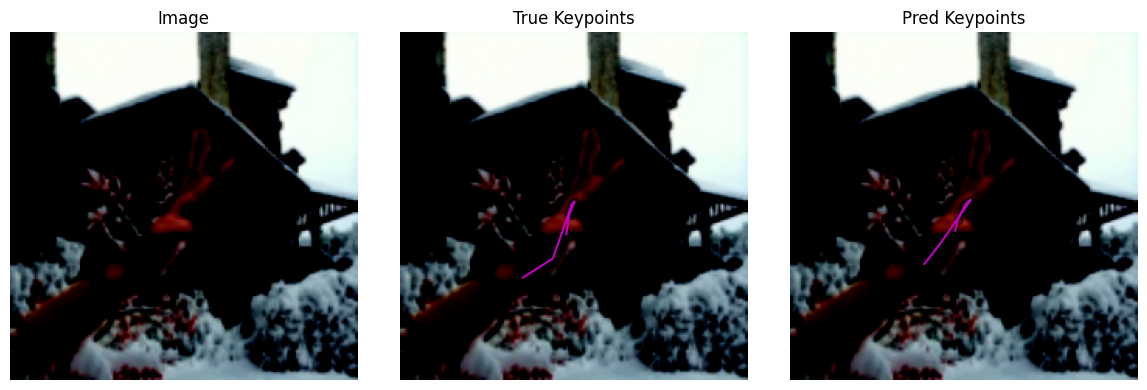

Epoch: 22/1000, Train Loss=0.2648048616, Val Loss=0.3009179311


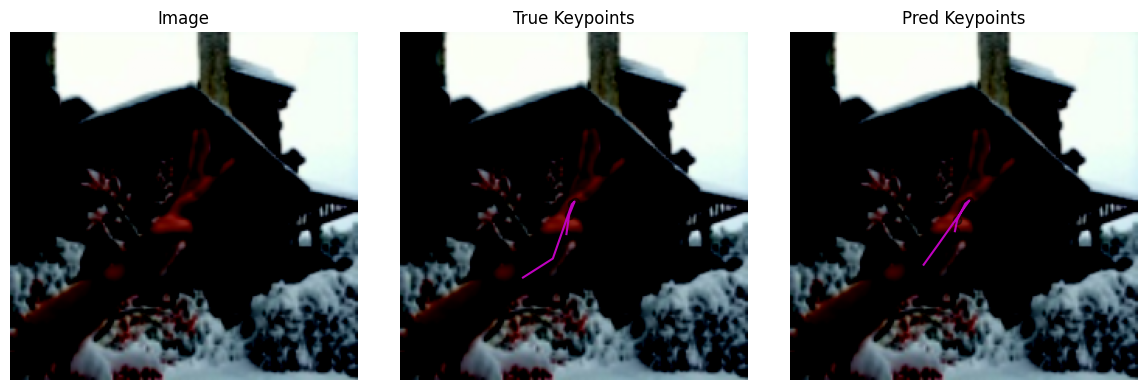

KeyboardInterrupt: ignored

time: 43min 17s (started: 2023-08-22 03:20:06 +00:00)


In [29]:
# Jempol
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader)

In [30]:
class PostProcessOutput(nn.Module):
  def __init__(self, n_keypoint, heatmap_size):
      super().__init__()
      self.keypoint = n_keypoint
      self.size = heatmap_size

  def heatmaps_to_coordinates(self, heatmaps):

      # mendapatkan banyak image dalam batch
      # heatmaps = heatmaps.cpu()
      # heatmaps = heatmaps.detach().numpy()

      batch_size = heatmaps.shape[0]

      # mendapatkan nilai total dari heatmap width dan height
      sums = heatmaps.sum(dim=[2, 3], keepdim=True)

      # normalisasi heatmap dengan membagi nilai heatmap dengan nilai total heatmap
      # sehingga hasil berada pada range 0 dan 1
      normalized = heatmaps / sums

      # mendapatkan nilai total pada normalized heatmap dari width dan height nya
      x_prob = normalized.sum(axis=2)
      y_prob = normalized.sum(axis=3)

      # membuat heatmap baru sebagai kordinat dengan size 0 hingga 127 -> dimensi
      arr = torch.arange(0, self.size, dtype=torch.float32).unsqueeze(0).unsqueeze(1).cuda()
      arr = arr.expand(batch_size, self.keypoint, self.size)


      # mendapatkan kordinat dengan mengkalikan normalized vector heatmap dengan heatmap kordinat baru
      # ini bertujuan untuk meningkatkan keakuratan dari keypoint output menggunakan value yang telah di normalisasi
      x = (arr * x_prob).sum(axis=2)
      y = (arr * y_prob).sum(axis=2)

      # register kordinat pada array
      keypoints = torch.stack([x, y], dim=-1)
      keypoints = keypoints / self.size

      return keypoints

  def forward(self, x):
      return self.heatmaps_to_coordinates(x)


class KeypointPredictor(nn.Module):
  def __init__(self, in_channel, out_channel, UnetModel):
      super().__init__()
      self.post_processing = PostProcessOutput(out_channel, 128)
      self.unet = UnetModel

  def forward(self, x):
      heatmaps = self.unet.forward(x)
      post_processed = self.post_processing(heatmaps)
      return post_processed


time: 4.38 ms (started: 2023-08-22 04:04:09 +00:00)


In [40]:
predictor = KeypointPredictor(3, N_KEYPOINTS, model)
# predictor.eval()
# torch.quantization.convert(model, inplace=True)

time: 686 µs (started: 2023-08-22 04:06:53 +00:00)


In [33]:
# melakukan testing
accuracy_all_image = []
accuracy_per_keypoint = [0] * N_KEYPOINTS

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_keypoints = model(inputs)
    # print(pred_heatmaps)
    pred_keypoints = pred_keypoints.cpu()
    pred_keypoints = pred_keypoints.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_keypoints)

    batched_accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    for accuracy_keypoint in batched_accuracy_keypoint:
      accuracy_per_keypoint = accuracy_per_keypoint +  accuracy_keypoint

    accuracy_image = batched_accuracy_keypoint.mean(axis=1)
    accuracy_all_image.extend(list(accuracy_image))

100%|██████████| 1000/1000 [00:17<00:00, 56.97it/s]

time: 17.6 s (started: 2023-08-22 04:05:08 +00:00)


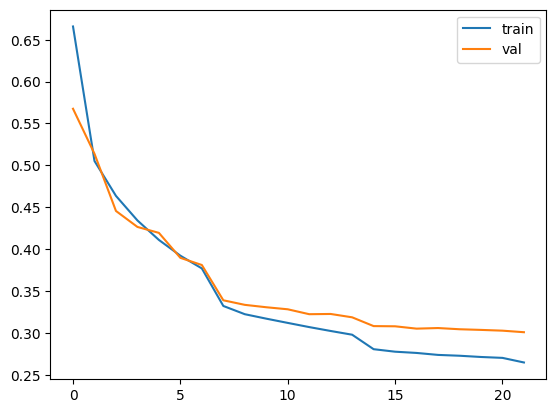

time: 701 ms (started: 2023-08-22 04:05:27 +00:00)


In [34]:
#visualisasi graphic training dan eval
plt.plot(trainer.loss["train"], label="train")
plt.plot(trainer.loss["val"], label="val")
plt.legend()
plt.show()

In [35]:
error = np.mean(accuracy_all_image)
print("Average error per keypoint: {:.1f}% from image size".format(error * 100))

for img_size in [MODEL_IMG_SIZE, RAW_IMG_SIZE]:
    error_pixels = error * img_size
    image_size = f"{img_size}x{img_size}"
    print(
        "Average error per keypoint: {:.0f} pixels for image {}".format(
            error_pixels, image_size
        )
    )


Average error per keypoint: 4.6% from image size
Average error per keypoint: 6 pixels for image 128x128
Average error per keypoint: 10 pixels for image 224x224
time: 24.6 ms (started: 2023-08-22 04:05:28 +00:00)


In [36]:
accuracy_per_keypoint/1000

array([0.0429901 , 0.04608809, 0.04389341, 0.03779621, 0.04409233,
       0.05905531])

time: 3.55 ms (started: 2023-08-22 04:05:35 +00:00)


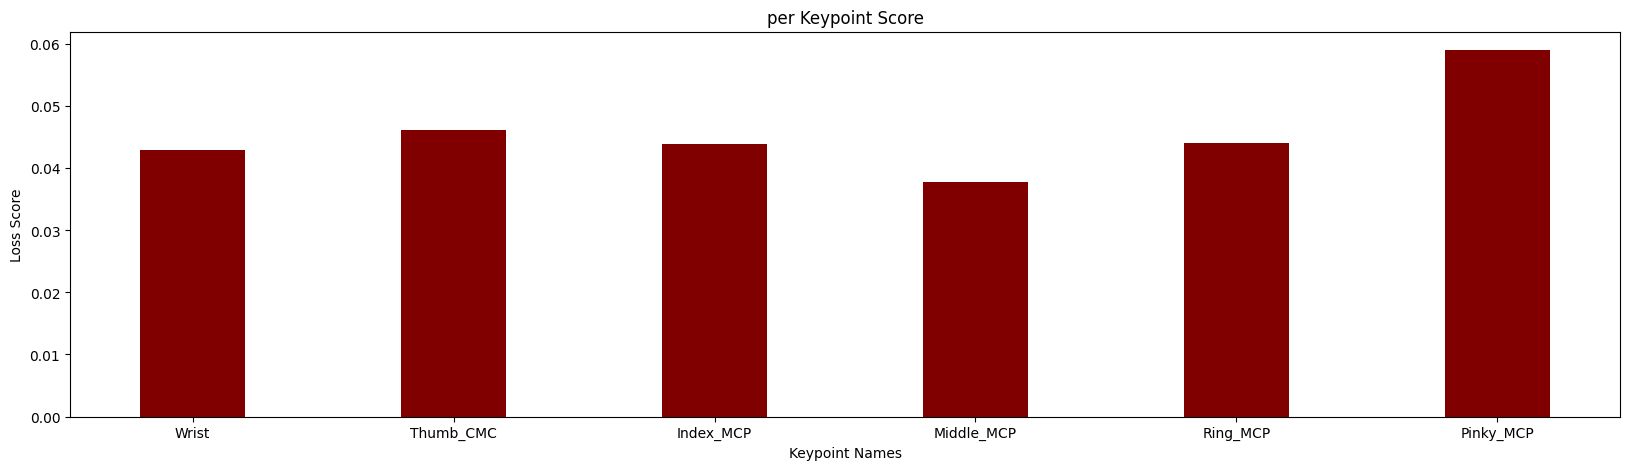

time: 348 ms (started: 2023-08-22 04:05:43 +00:00)


In [37]:
accuracy_per_keypoint_mean = accuracy_per_keypoint / 1000
fig = plt.figure(figsize=(20,5))
plt.bar(KEYS_KEYPOINTS, accuracy_per_keypoint_mean, color= 'maroon', width=0.4)
plt.xlabel("Keypoint Names")
plt.ylabel("Loss Score")
plt.title("per Keypoint Score")
plt.show()

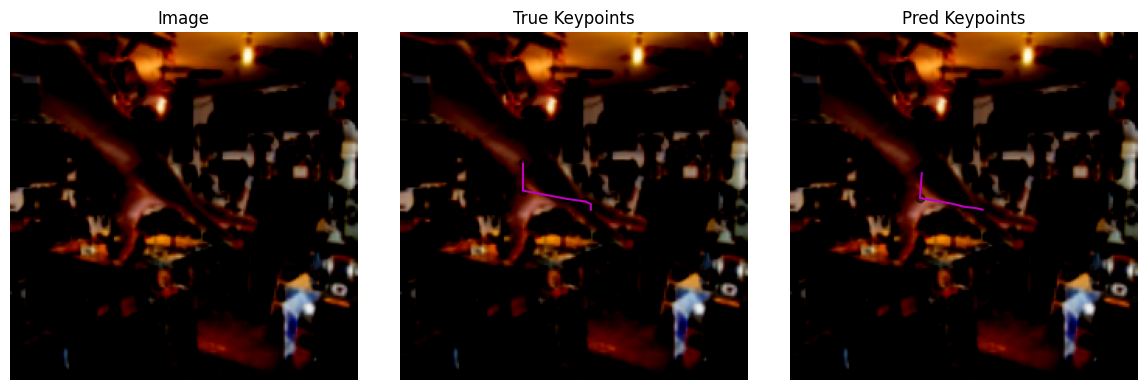

time: 644 ms (started: 2023-08-22 04:06:04 +00:00)


In [38]:
# visualisasi testing
for data in test_dataloader:
    show_batch_predictions(data, model)
    break

In [39]:
torch.save(trainer.best_model, "/content/MCP Best pytrch")

time: 17.8 ms (started: 2023-08-22 04:06:22 +00:00)


In [41]:
!pip install onnx
import onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 62.0 MB/s eta 0:00:00
time: 9.39 s (started: 2023-08-22 04:07:20 +00:00)


In [42]:

dummy_input = torch.randn(1, 3, 128, 128)
dummy_input = dummy_input.to(test_config["device"])
torch.onnx.export(
         predictor,
         dummy_input,
         "MCP BEST.onnx",
         export_params=True,
         opset_version=11,
         do_constant_folding=True,
         input_names = ['input'],
         output_names = ['output'])

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

time: 745 ms (started: 2023-08-22 04:07:38 +00:00)


In [43]:
!pip install onnx_tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 40.2 MB/s eta 0:00:00
time: 6.24 s (started: 2023-08-22 04:08:13 +00:00)


In [44]:
import tensorflow as tf
import onnx_tf

time: 4.75 s (started: 2023-08-22 04:08:19 +00:00)


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [45]:
onnx_model = onnx.load("MCP BEST.onnx")

time: 5.67 ms (started: 2023-08-22 04:08:39 +00:00)


In [46]:
tf_model_path = 'MCP BEST.pb'
tf_rep = onnx_tf.backend.prepare(onnx_model)
tf_rep.export_graph(tf_model_path)

time: 33.6 s (started: 2023-08-22 04:08:40 +00:00)


In [47]:
converter = tf.compat.v1.lite.TFLiteConverter.from_saved_model(tf_model_path)
tflite_model = converter.convert()

Instructions for updating:
Use `tf.saved_model.load` instead.
INFO:absl:Using experimental converter: If you encountered a problem please file a bug. You can opt-out by setting experimental_new_converter=False


time: 5.46 s (started: 2023-08-22 04:09:14 +00:00)


In [48]:
with open('MCP BEST.tflite', 'wb') as f:
  f.write(tflite_model)

time: 1.06 ms (started: 2023-08-22 04:09:19 +00:00)


In [ ]:
# telunjuk
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader)

Epoch: 1/1000, Train Loss=0.9804675388, Val Loss=0.979360799
Epoch: 2/1000, Train Loss=0.9752876091, Val Loss=0.9636482298
Epoch: 3/1000, Train Loss=0.9271354198, Val Loss=0.9462869366
Epoch: 4/1000, Train Loss=0.8819528174, Val Loss=0.8845884303
Epoch: 5/1000, Train Loss=0.8533201623, Val Loss=0.8466950456
Epoch: 6/1000, Train Loss=0.8207150698, Val Loss=0.9642372827
Epoch: 7/1000, Train Loss=0.8315256, Val Loss=0.9728726645
Epoch: 8/1000, Train Loss=0.7961659408, Val Loss=0.8128094276
Epoch: 9/1000, Train Loss=0.7727702475, Val Loss=0.8487172127
Epoch: 10/1000, Train Loss=0.767470367, Val Loss=0.7629195154
Epoch: 11/1000, Train Loss=0.7472482896, Val Loss=0.801014324
Epoch: 12/1000, Train Loss=0.7260301232, Val Loss=0.7735178371
Epoch: 13/1000, Train Loss=0.7057805419, Val Loss=0.7733808259
Epoch: 14/1000, Train Loss=0.7198242426, Val Loss=0.8035688798
Epoch: 15/1000, Train Loss=0.7119411707, Val Loss=0.8060020705
Epoch: 16/1000, Train Loss=0.6691056085, Val Loss=0.7332062125
Epoch: 

In [ ]:
# tengah
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader)

Epoch: 1/1000, Train Loss=0.9777159142, Val Loss=0.9727719426
Epoch: 2/1000, Train Loss=0.9494950771, Val Loss=0.9234427015
Epoch: 3/1000, Train Loss=0.8803635931, Val Loss=0.8918807407
Epoch: 4/1000, Train Loss=0.8471411228, Val Loss=0.907360067
Epoch: 5/1000, Train Loss=0.8217914033, Val Loss=0.822172145
Epoch: 6/1000, Train Loss=0.8107694006, Val Loss=0.8439527551
Epoch: 7/1000, Train Loss=0.781650703, Val Loss=0.8628822267
Epoch: 8/1000, Train Loss=0.7941486621, Val Loss=0.8062145213
Epoch: 9/1000, Train Loss=0.7614957356, Val Loss=0.8613048891
Epoch: 10/1000, Train Loss=0.7613675141, Val Loss=0.855339994
Epoch: 11/1000, Train Loss=0.6987977433, Val Loss=0.810434709
Epoch: 12/1000, Train Loss=0.7248124123, Val Loss=0.801712513
Epoch: 13/1000, Train Loss=0.687291193, Val Loss=0.864185969
Epoch: 14/1000, Train Loss=0.6895549011, Val Loss=0.8524511755
Epoch: 15/1000, Train Loss=0.6736863089, Val Loss=0.8585266868
Epoch: 16/1000, Train Loss=0.6572060513, Val Loss=0.7852968474
Epoch: 17

In [ ]:
# manis
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader)

Epoch: 1/1000, Train Loss=0.9793922448, Val Loss=0.9773307939
Epoch: 2/1000, Train Loss=0.9658726811, Val Loss=0.9436274767
Epoch: 3/1000, Train Loss=0.919340229, Val Loss=0.9344090819
Epoch: 4/1000, Train Loss=0.8645070934, Val Loss=0.8909892837
Epoch: 5/1000, Train Loss=0.8420865989, Val Loss=0.9046646555
Epoch: 6/1000, Train Loss=0.8264140081, Val Loss=0.8854975402
Epoch: 7/1000, Train Loss=0.8341310143, Val Loss=0.9379301369
Epoch: 8/1000, Train Loss=0.7892002869, Val Loss=0.7901650469
Epoch: 9/1000, Train Loss=0.7733193183, Val Loss=0.7607796292
Epoch: 10/1000, Train Loss=0.764366672, Val Loss=0.8525663018
Epoch: 11/1000, Train Loss=0.7522732663, Val Loss=0.7190312246
Epoch: 12/1000, Train Loss=0.7172399998, Val Loss=0.7890889843
Epoch: 13/1000, Train Loss=0.735771358, Val Loss=0.7649128636
Epoch: 14/1000, Train Loss=0.6997681141, Val Loss=0.8263671498
Epoch: 15/1000, Train Loss=0.6949317837, Val Loss=0.7057613333
Epoch: 16/1000, Train Loss=0.6795996118, Val Loss=0.7900008758
Epoc

In [ ]:
# kelingking
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader)

Epoch: 1/1000, Train Loss=0.9803606677, Val Loss=0.9794328709
Epoch: 2/1000, Train Loss=0.9767865348, Val Loss=0.9727155765
Epoch: 3/1000, Train Loss=0.948943727, Val Loss=0.9326863289
Epoch: 4/1000, Train Loss=0.9143071938, Val Loss=0.91814966
Epoch: 5/1000, Train Loss=0.8992816877, Val Loss=0.9755199949
Epoch: 6/1000, Train Loss=0.8673205471, Val Loss=0.9087355336
Epoch: 7/1000, Train Loss=0.8597844505, Val Loss=0.8733879328
Epoch: 8/1000, Train Loss=0.8542074895, Val Loss=0.8508638044
Epoch: 9/1000, Train Loss=0.8274656558, Val Loss=0.8524701496
Epoch: 10/1000, Train Loss=0.8292061281, Val Loss=0.8218060136
Epoch: 11/1000, Train Loss=0.804447782, Val Loss=0.8396296501
Epoch: 12/1000, Train Loss=0.7925015879, Val Loss=0.8434279164
Epoch: 13/1000, Train Loss=0.7760662961, Val Loss=0.8112406035
Epoch: 14/1000, Train Loss=0.7572328949, Val Loss=0.7966783643
Epoch: 15/1000, Train Loss=0.7308731985, Val Loss=0.7883494198
Epoch: 16/1000, Train Loss=0.732119236, Val Loss=0.81299148
Epoch: 1

In [ ]:
# ruas mcp
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader)

Epoch: 1/1000, Train Loss=0.9809670305, Val Loss=0.9799068769
Epoch: 2/1000, Train Loss=0.9776712584, Val Loss=0.9736739794
Epoch: 3/1000, Train Loss=0.960227313, Val Loss=0.9441197415
Epoch: 4/1000, Train Loss=0.9120343947, Val Loss=0.8700304627
Epoch: 5/1000, Train Loss=0.8740403938, Val Loss=0.9066390196
Epoch: 6/1000, Train Loss=0.8338435078, Val Loss=0.8628266354
Epoch: 7/1000, Train Loss=0.8238045192, Val Loss=0.8575564722
Epoch: 8/1000, Train Loss=0.8084594989, Val Loss=0.8620881339
Epoch: 9/1000, Train Loss=0.8118631005, Val Loss=0.8086261054
Epoch: 10/1000, Train Loss=0.7777485156, Val Loss=0.7865977287
Epoch: 11/1000, Train Loss=0.7800431609, Val Loss=0.8051293691
Epoch: 12/1000, Train Loss=0.7570430279, Val Loss=0.7494694591
Epoch: 13/1000, Train Loss=0.7299236608, Val Loss=0.7973334889
Epoch: 14/1000, Train Loss=0.7240436363, Val Loss=0.7683300674
Epoch: 15/1000, Train Loss=0.7018461251, Val Loss=0.7863928775
Epoch: 16/1000, Train Loss=0.6792540789, Val Loss=0.7099521061
Ep

In [ ]:
# ruas tengah
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader)

Epoch: 1/1000, Train Loss=0.9809532237, Val Loss=0.9808499018
Epoch: 2/1000, Train Loss=0.9792581487, Val Loss=0.9785383542
Epoch: 3/1000, Train Loss=0.9727383041, Val Loss=0.9573393464
Epoch: 4/1000, Train Loss=0.9132025027, Val Loss=0.9169429739
Epoch: 5/1000, Train Loss=0.8720101738, Val Loss=0.8919655283
Epoch: 6/1000, Train Loss=0.8354884791, Val Loss=0.8578805228
Epoch: 7/1000, Train Loss=0.8051939583, Val Loss=0.8632788062
Epoch: 8/1000, Train Loss=0.81039639, Val Loss=0.9580316742
Epoch: 9/1000, Train Loss=0.7901893306, Val Loss=0.7951356371
Epoch: 10/1000, Train Loss=0.7580725551, Val Loss=0.8124343852
Epoch: 11/1000, Train Loss=0.7413304853, Val Loss=0.8216251731
Epoch: 12/1000, Train Loss=0.7304359913, Val Loss=0.8307012916
Epoch: 13/1000, Train Loss=0.7090682244, Val Loss=0.7883085608
Epoch: 14/1000, Train Loss=0.710008173, Val Loss=0.7651496828
Epoch: 15/1000, Train Loss=0.6998103309, Val Loss=0.7866273324
Epoch: 16/1000, Train Loss=0.6899465895, Val Loss=0.7762260735
Epoc

In [ ]:
# ruas dip
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader)

Epoch: 1/1000, Train Loss=0.9808165264, Val Loss=0.9805957576
Epoch: 2/1000, Train Loss=0.9793686986, Val Loss=0.9786003033
Epoch: 3/1000, Train Loss=0.9746195316, Val Loss=0.9648467898
Epoch: 4/1000, Train Loss=0.9379750562, Val Loss=0.9276895722
Epoch: 5/1000, Train Loss=0.8985274673, Val Loss=0.9050165812
Epoch: 6/1000, Train Loss=0.8634040403, Val Loss=0.9329595069
Epoch: 7/1000, Train Loss=0.838922987, Val Loss=0.8742573857
Epoch: 8/1000, Train Loss=0.816736331, Val Loss=0.8933958809
Epoch: 9/1000, Train Loss=0.799887104, Val Loss=0.8157087465
Epoch: 10/1000, Train Loss=0.7671073914, Val Loss=0.797598958
Epoch: 11/1000, Train Loss=0.7449922895, Val Loss=0.8199471037
Epoch: 12/1000, Train Loss=0.7421717453, Val Loss=0.849828889
Epoch: 13/1000, Train Loss=0.7301441908, Val Loss=0.7499636014
Epoch: 14/1000, Train Loss=0.7076594424, Val Loss=0.7820530136
Epoch: 15/1000, Train Loss=0.7060846066, Val Loss=0.7419550816
Epoch: 16/1000, Train Loss=0.7200733542, Val Loss=0.7698718607
Epoch:

In [ ]:
# ruas tip
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader)

Epoch: 1/1000, Train Loss=0.9796229863, Val Loss=0.9785971145
Epoch: 2/1000, Train Loss=0.9767762208, Val Loss=0.9733663698
Epoch: 3/1000, Train Loss=0.9564230204, Val Loss=0.9328414698
Epoch: 4/1000, Train Loss=0.9107961106, Val Loss=0.923203369
Epoch: 5/1000, Train Loss=0.8831939435, Val Loss=0.9724949598
Epoch: 6/1000, Train Loss=0.8644466519, Val Loss=0.8694661657
Epoch: 7/1000, Train Loss=0.8538083363, Val Loss=0.865990748
Epoch: 8/1000, Train Loss=0.8217219234, Val Loss=0.9657531579
Epoch: 9/1000, Train Loss=0.8225327849, Val Loss=0.8367614845
Epoch: 10/1000, Train Loss=0.8148343754, Val Loss=0.8473241727
Epoch: 11/1000, Train Loss=0.7867145896, Val Loss=0.8101827502
Epoch: 12/1000, Train Loss=0.7715093541, Val Loss=0.810677141
Epoch: 13/1000, Train Loss=0.7632124019, Val Loss=0.8113401433
Epoch: 14/1000, Train Loss=0.7429575014, Val Loss=0.7813924849
Epoch: 15/1000, Train Loss=0.7496752095, Val Loss=0.8289948404
Epoch: 16/1000, Train Loss=0.7445463467, Val Loss=0.8051188986
Epoc